运用设计好的hand segmentation + hand differentiation算法，将原始数据集（只含`hand`标签）修改为含`left_hand`和`right_hand`的标签的数据集。

In [1]:
CLS = ['hand']
NEW_CLS = ['left_hand', 'right_hand']
IMAGE = 'yolov3/data/samples/0000004831.jpg'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cv2
import numpy as np 
import torch
from differentiate import *
import matplotlib.pyplot as plt 
from yolov3.utils.utils import xywh2xyxy, xyxy2xywh
import os
import shutil
from tqdm import tqdm
import glob

# 不同数据类型和torch tensor的转换

In [4]:
# array
img = cv2.imread(IMAGE)
print(
    '\nimg type: ', type(img),
    '\nimg shape: ', img.shape
)


img type:<class 'numpy.ndarray'>
img shape:(1080, 1920, 3)


In [6]:
# array
boxes = np.array(
    [
        [0, 0.8236, 1119, 741, 1315, 960],
        [0, 0.2, 350, 773, 500, 900],
        [0, 0.74608, 620, 734, 846, 1034]
    ]
)
print(
    '\nboxes type: ', type(boxes),
    '\nboxes shape: ', boxes.shape
)


boxes type:<class 'numpy.ndarray'>
boxes shape:(3, 6)


In [5]:
# array to tensor
img_tensor = torch.from_numpy(img)
print(
    '\nimg_tensor type: ', type(img_tensor),
    '\nimg_tensor shape: ', img_tensor.shape
)


img_tensor type:<class 'torch.Tensor'>
img_tensor shape:torch.Size([1080, 1920, 3])


In [7]:
# array to tensor
boxes_tensor = torch.from_numpy(boxes)
print(
    '\nboxes_tensor type: ', type(boxes_tensor),
    '\nboxes_tensor shape: ', boxes_tensor.shape
)


boxes_tensor type:<class 'torch.Tensor'>
boxes_tensor shape:torch.Size([3, 6])


In [10]:
# tensor to array
img_tensor2array = img_tensor.numpy()
print(
    '\nimg_tensor2array type: ', type(img_tensor2array),
    '\nimg_tensor2array shape: ', img_tensor2array.shape
)


img_tensor2array type:<class 'numpy.ndarray'>
img_tensor2array shape:(1080, 1920, 3)


发现np array和torch tensor的维度安排是一致的，所以很好切换。

In [15]:
# list
boxes = [[0, 0.689323, 0.683796, 0.095312, 0.197222]]
print(
    '\nboxes: ', boxes,
    '\nboxes type: ', type(boxes),
    '\nboxes num|box length: {}|{}'.format(len(boxes), len(boxes[0]))
)


boxes:[[0, 0.689323, 0.683796, 0.095312, 0.197222]]
boxes type:<class 'list'>
boxes num|box length: 1|5


In [16]:
# list to tensor
boxes_tensor = torch.as_tensor(boxes)
print(
    '\nboxes_tensor: ', boxes_tensor,
    '\nboxes_tensor type: ', type(boxes_tensor),
    '\nboxes_tensor shape: ', boxes_tensor.shape
)


boxes_tensor:tensor([[0.00000, 0.68932, 0.68380, 0.09531, 0.19722]])
boxes_tensor type:<class 'torch.Tensor'>
boxes_tensor shape:torch.Size([1, 5])


list到tensor的转换也很简单，维度也基本一致。

# 运用inference算法修改数据集

**暂时的inference算法（hand segmentation + hand differentiation）的代码全部都用的是numpy版本，hand detection的代码虽然是pytorch版，但是修改数据集直接读取原始数据，无需detection，所以修改数据集的代码也暂时设计为numpy版本，以后肯定会全部替换为更快的pytorch版**。时间紧迫，纯属无奈之举。

In [12]:
# 读取一个数据集中一张图片的标注，将其转化为boxes (format: cls_id, conf, xmin, ymin, xmax, ymax)

In [157]:
DS_PATH = '../datasets/ego-hand'
ANN_PATH = '../datasets/ego-hand/labels/P21_04_0000010441.txt'
IMG_PATH = '../datasets/ego-hand/images/P21_04_0000010441.jpg'

In [158]:
boxes = get_ann_boxes(ANN_PATH)
np_boxes = np.asarray(boxes)

# xywh boxes to xyxy boxes
np_boxes[:, 1:] = xywh2xyxy(np_boxes[:, 1:])
np_boxes[:, 1:] = np.clip(np_boxes[:, 1:], 0, 1)

# Rescale to image shape
np_boxes[:, 1:] = scale_xyxy(np_boxes[:, 1:], img.shape[:2])

# 首先由于是从原始数据导入标注，没有置信度数据，手动加上凑数，反正是不需要的，原始数据没有单张图片有三只手的情况，不用担心在缩减boxes这一步出现问题。
irt_np_boxes = np.insert(np_boxes, 1, 1, axis=1)

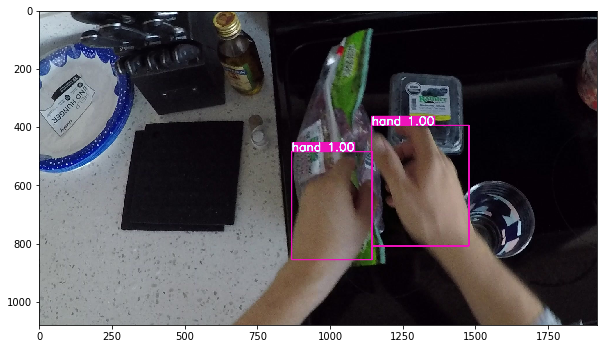

In [159]:
# 测试一下
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dst = write_result(irt_np_boxes, img, CLS)
plt.figure(figsize=(10, 8))
plt.imshow(dst)
plt.show()

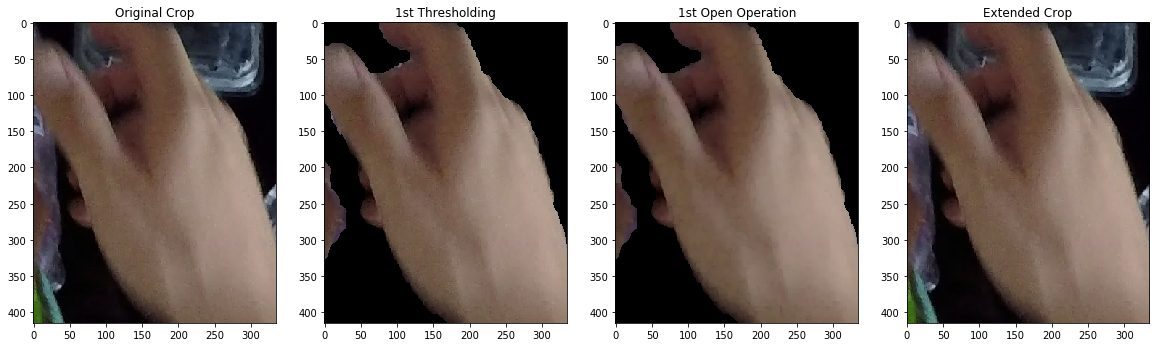

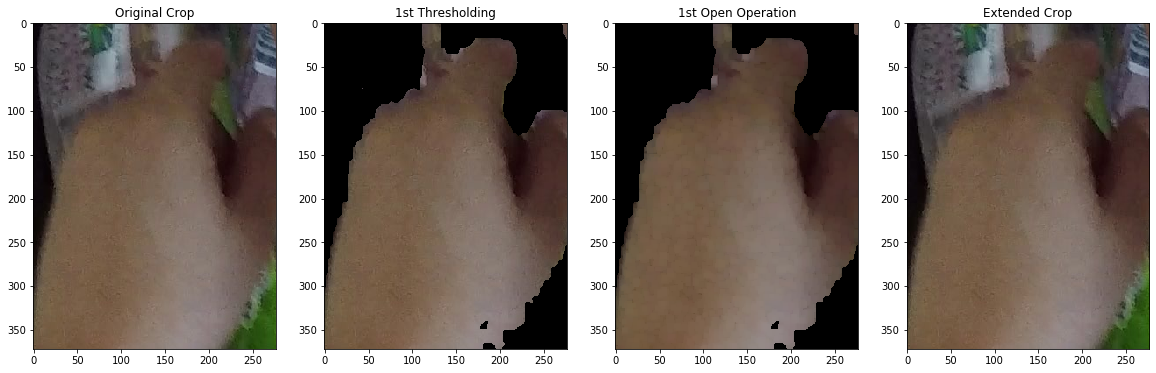

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:353: error: (-201:Incorrect size of input array) There should be at least 5 points to fit the ellipse in function 'cv::fitEllipse'


In [160]:
# 做一次differentiation
# 采用较小的二值化阈值，就需要计算最大面积区域来确定手
lr_boxes = diff_hands(img, irt_np_boxes, extend_scale=0, color_thres=10, bin_thres=5, max_region=False, view=True)
boxes_info(lr_boxes, NEW_CLS)

dst = write_result(lr_boxes, img, NEW_CLS)
plt.figure(figsize=(10, 8))
plt.imshow(dst)
plt.show()

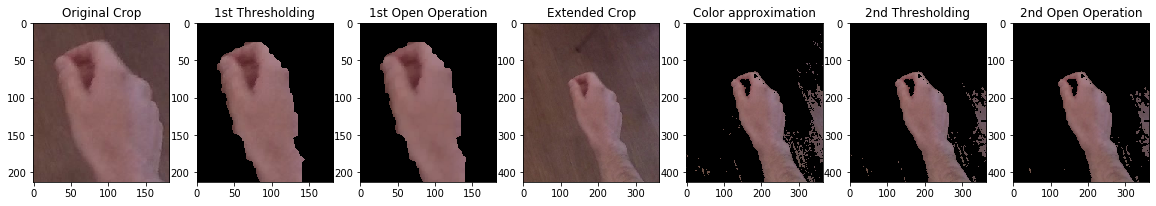

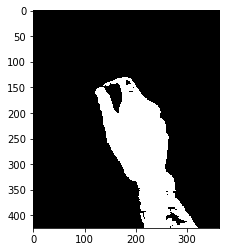

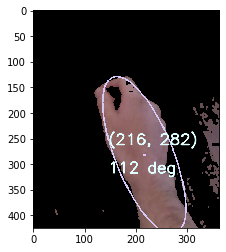


Normalised bounding box 0: right_hand
  conf    LT_x    LT_y    RB_x    RB_y
------  ------  ------  ------  ------
     1    1232     632    1415     845


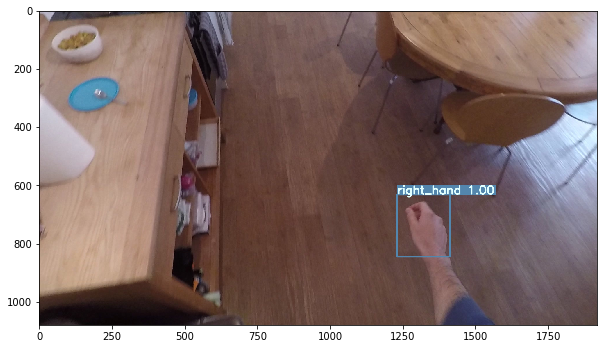

In [191]:
# 否则就设置大一点的二值化阈值
# 但是不一定有输出，如设置bin_thres=200
lr_boxes = diff_hands(img, irt_np_boxes, bin_thres=100, view=True)
boxes_info(lr_boxes, NEW_CLS)

dst = write_result(lr_boxes, img, NEW_CLS)
plt.figure(figsize=(10, 8))
plt.imshow(dst)
plt.show()

In [192]:
# 现在完成了一个标注文件的读取和处理
# 把生成的新标注按照相同方式保存起来

In [194]:
diff_labels_path = os.path.join(DS_PATH, 'diff_labels')
if os.path.exists(diff_labels_path):
    shutil.rmtree(diff_labels_path)  # delete output folder
os.makedirs(diff_labels_path)  # make new output folder

In [195]:
# Labels
with open(os.path.join(DS_PATH, 'diff.names'), 'w') as f:
    for n in NEW_CLS:
        f.write('%s\n' % n)

In [202]:
np_boxes = np.asarray(boxes)
np_boxes[:, 0] = lr_boxes[:, 0]
np_boxes

array([[          1,     0.68932,      0.6838,    0.095312,     0.19722]])

In [204]:
# Save new annotation file
new_ann_path = os.path.join(diff_labels_path, os.path.basename(ANN_PATH))
with open(new_ann_path, 'w') as f:
    for np_box in np_boxes:
        f.write(('%g ' * 5 + '\n') % (*np_box[:],))

In [205]:
# 对整个数据集操作




Images: 0it [00:00, ?it/s]
               Image               Hands

P01_02_0000000181.jpg                   1


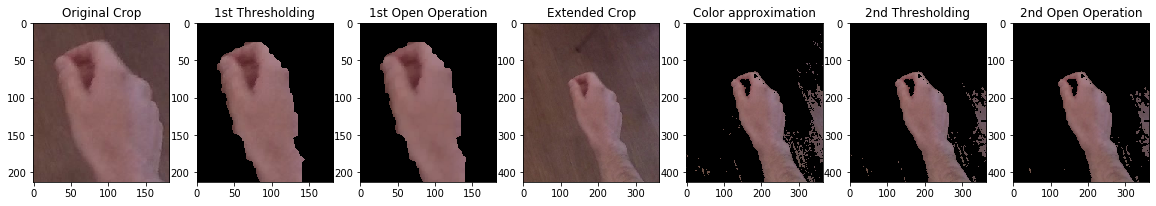

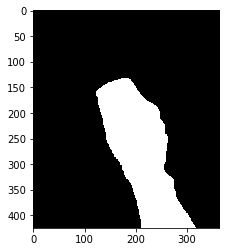

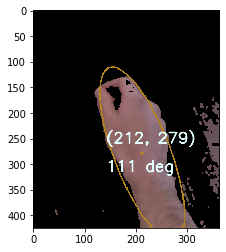




Images: 1it [00:01,  1.75s/it]
               Image               Hands

P01_02_0000000211.jpg                   1


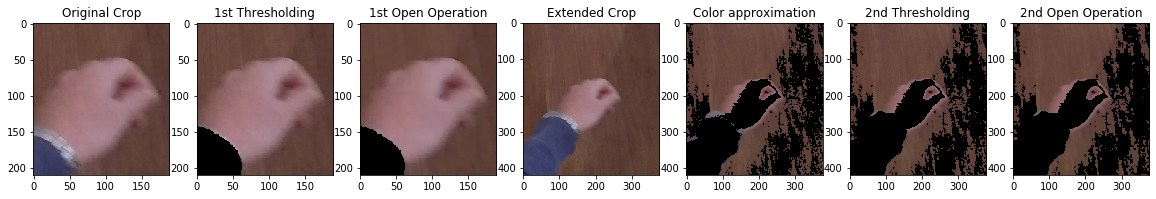

Images: 1it [00:03,  3.85s/it]


error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:353: error: (-201:Incorrect size of input array) There should be at least 5 points to fit the ellipse in function 'cv::fitEllipse'


In [223]:
DS_PATH = '../datasets/ego-hand'
img_paths = sorted(glob.glob(DS_PATH + '/images/' + '*.jpg'))
ann_paths = sorted(glob.glob(DS_PATH + '/labels/' + '*.txt'))

# New folder
diff_labels_path = os.path.join(DS_PATH, 'diff_labels')
if os.path.exists(diff_labels_path):
    shutil.rmtree(diff_labels_path)  # delete output folder
os.makedirs(diff_labels_path)  # make new output folder

# Labels
with open(os.path.join(DS_PATH, 'diff.names'), 'w') as f:
    for n in NEW_CLS:
        f.write('%s\n' % n)

for ip, ap in tqdm(zip(img_paths, ann_paths), desc='Images'):
    # Read original annotation
    img = cv2.imread(ip)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = get_ann_boxes(ap)
    np_boxes = np.asarray(boxes)
    np_boxes[:, 1:] = xywh2xyxy(np_boxes[:, 1:])
    np_boxes[:, 1:] = scale_xyxy(np_boxes[:, 1:], img.shape[:2])
    irt_np_boxes = np.insert(np_boxes, 1, 1, axis=1)

    # Info output
    print(('\n' + '%20s' * 2) % ('Image', 'Hands'))
    print(('\n' + '%20s' * 2) % (os.path.basename(ap)[:-4] + '.jpg', np_boxes.shape[0]))

    # Differentiation
    lr_boxes = diff_hands(img, irt_np_boxes, bin_thres=10, max_region=True, view=True)
    np_boxes = np.asarray(boxes)
    np_boxes[:, 0] = lr_boxes[:, 0]

    # Write new annotation
    new_ann_path = os.path.join(diff_labels_path, os.path.basename(ap))
    with open(new_ann_path, 'w') as f:
        for np_box in np_boxes:
            f.write(('%g ' * 5 + '\n') % (*np_box[:],))

如果要消除这个bug，就得把max_region=False，这样带来的是非常多的不准确。见`grow-dataset.py`。

是怎么修改完数据集的呢？

能够用skin mask方法跑过的就用它跑，否则换用kmeans mask方法，不保证准确率，只保证能跑通，而且通过设置restart从出问题的位置重新开始。

## darknet-to-supervisely

In [195]:
import json
DS_PATH = '../datasets/ego-hand'
SAVE_PATH = '../datasets/epichands'
SAVE_ANN_PATH = SAVE_PATH + '/epichands/ann'
SAVE_IMG_PATH = SAVE_PATH + '/epichands/img'
img_paths = sorted(glob.glob(DS_PATH + '/images/' + '*.jpg'))
ann_paths = sorted(glob.glob(DS_PATH + '/diff_labels/' + '*.txt'))
NAMES = ['left_hand', 'right_hand']

# ego-hand
# -ego-hand
#   -ann
#       -1.jpg.json
#   -img
#       -1.jpg
# -meta.json

# https://docs.supervise.ly/data-organization/import-export/supervisely-format
# https://docs.supervise.ly/data-organization/import-export/upload

In [196]:
# New folder
super_ann_path = os.path.join(SAVE_PATH)

if os.path.exists(SAVE_PATH):
    shutil.rmtree(SAVE_PATH) 
os.makedirs(SAVE_ANN_PATH) 
os.makedirs(SAVE_IMG_PATH) 

In [197]:
# json for the whole project
meta = {
    "classes": [
        {
            "title": NAMES[0],
            "shape": "rectangle",
            "color": "#e67e22",
            "geometry_config": {}
        },
        {
            "title": NAMES[1],
            "shape": "rectangle",
            "color": "#2980b9",
            "geometry_config": {}
        }
    ],
    "tags": []
}

with open(os.path.join(SAVE_PATH, 'meta.json'), 'w') as f:
    json.dump(meta, f, indent=True)

In [198]:
# json for an image
for i in tqdm(range(len(img_paths)), desc='Images'):
    ip = img_paths[i]
    ap = ann_paths[i]
    ann_json = {
        "description": "",
        "tags": [],
        "size": {},
        "objects": []
    }
    # Read image size
    img = cv2.imread(ip)
    h, w = img.shape[:2]
    ann_json['size']['height']=h
    ann_json['size']['width']=w

    # Read bounding boxes
    boxes = get_ann_boxes(ap)
    for b in boxes: # b: (cls id, center x, center y, w, h)
        xmin = int(max(b[1] - b[3] / 2, 0) * w)
        ymin = int(max(b[2] - b[4] / 2, 0) * h)
        xmax = int(min(b[1] + b[3] / 2, 1) * w)
        ymax = int(min(b[2] + b[4] / 2, 1) * h)

        obj = {}
        obj['description'] = ''
        obj['geometryType'] = 'rectangle'
        obj['tags'] = []
        obj['classTitle'] = NAMES[int(b[0])]
        obj['points'] = {}
        obj['points']['exterior'] = []
        obj['points']['exterior'].append([xmin, ymin])
        obj['points']['exterior'].append([xmax, ymax])
        obj['points']['interior'] = []
        ann_json['objects'].append(obj)

    # Save json
    ann_json_path = os.path.join(SAVE_ANN_PATH, os.path.basename(ip) + '.json')
    with open(ann_json_path, 'w') as f:
        json.dump(ann_json, f, indent=True)
    
    # Copy image
    shutil.copy(ip, SAVE_IMG_PATH)

Images: 100%|██████████| 12846/12846 [11:08<00:00, 19.22it/s]


In [177]:
def get_ann_boxes(path):
    """Get boxes from the annotation of one image: cls_id, cx, cy, w, h
    """
    boxes = []
    with open(path, 'r') as f:
        for line in f:
            line = line[:-1].split()
            line[0] = int(line[0])  # cls id
            line[1:] = [float(i) for i in line[1:]]  # x y w h
            boxes.append(line)
    return boxes

## 重新创建数据集

In [2]:
PATH = '../datasets/epichands/epichands'

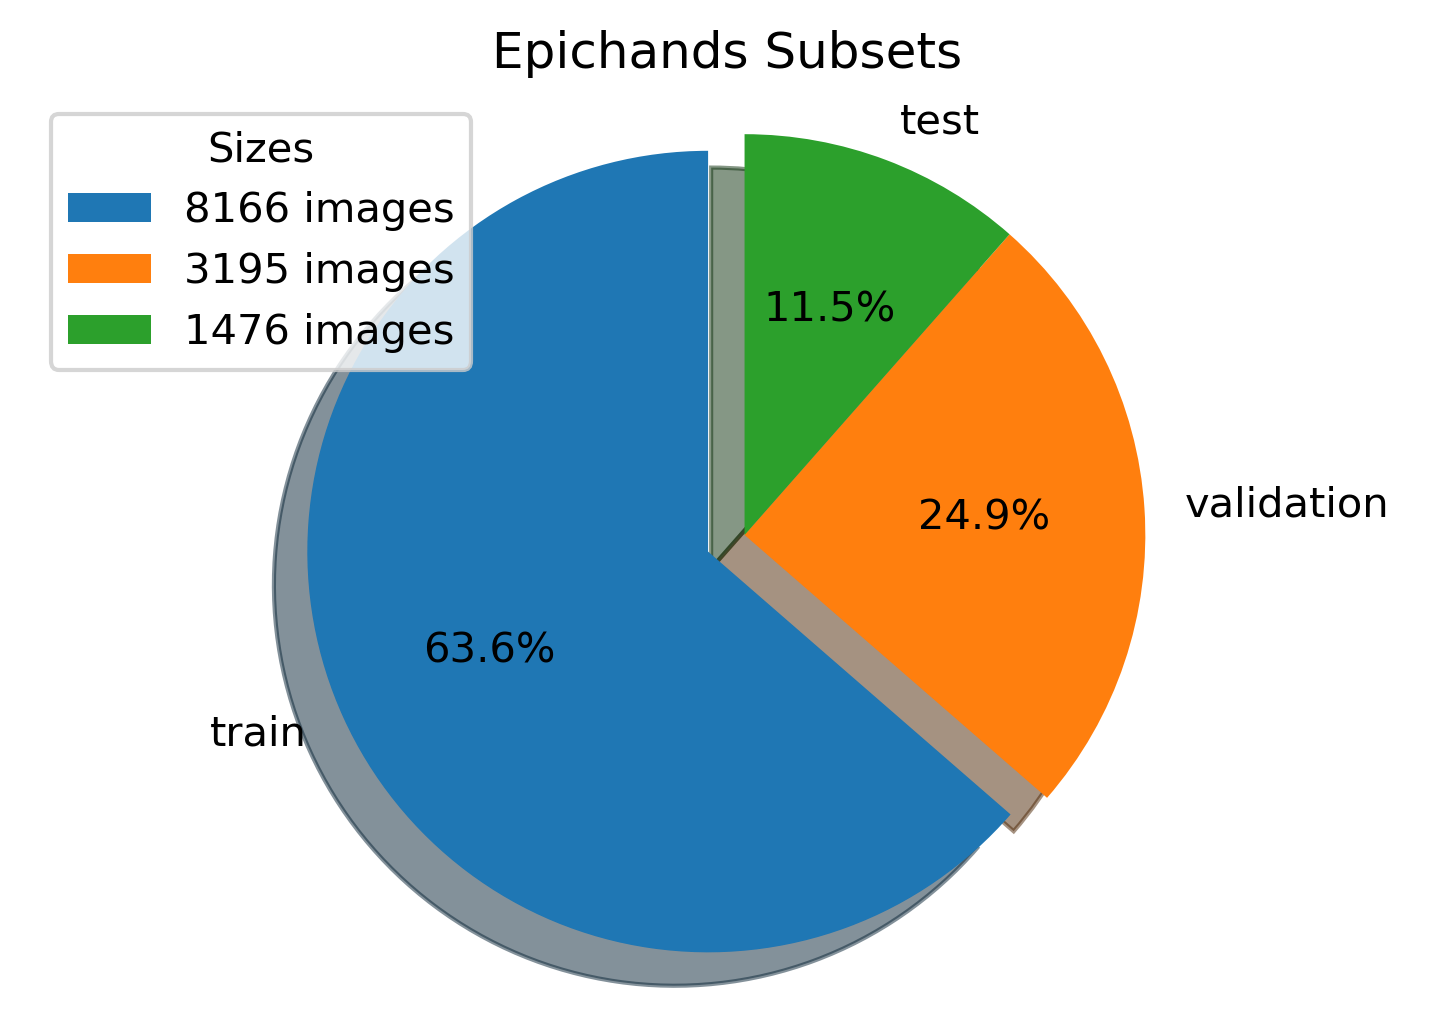

In [16]:
# 比例
datasets = {'train': 0, 'validation': 0, 'test': 0}
for l in datasets.keys():
    with open(os.path.join(PATH, l+'.txt'), 'r') as f:
        temp = f.readlines()
        datasets[l] = len(temp) 

# Visualise subsets information
subsets = [l for l in datasets.keys()]
sizes = [ss for ss in datasets.values()]
explode = (0.1, 0, 0)  # only "explode" the 1st slice (i.e. 'train')

fig1, ax1 = plt.subplots(dpi=300)
ax1.pie(sizes, explode=explode, labels=subsets, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.legend([str(s)+ ' images' for s in sizes], title='Sizes', loc='best')
plt.title("Epichands Subsets")


fig1.savefig("./images/epichhands-subsets.png")

plt.show()

In [1]:
# kmeans

Anchors are: 
[[ 37  52]
 [ 42  77]
 [ 45  89]
 [ 54  97]
 [ 57 114]
 [ 67 131]
 [ 78 137]
 [ 87 165]
 [100 204]]

Anchors saved to ../datasets/epichands/epichands\anchors.txt


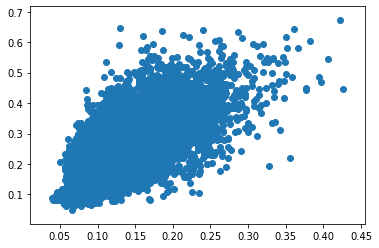

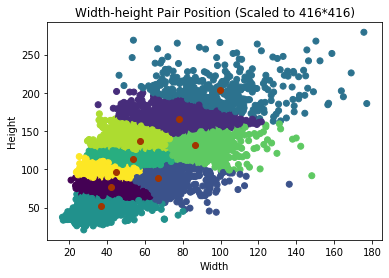

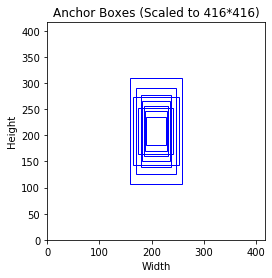

In [17]:
from func import kmeans_anchors
anchors = kmeans_anchors(os.path.join(PATH, 'train.txt'), save_path='./demo')